In [1]:
import json
import pickle
from time import time

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
# Classifiers obtained from http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# Original data

In [2]:
qas_df = pd.read_csv('data/qas.csv')

In [3]:
columns = ['Unnamed: 0', 'text', 'id']
qa_df = qas_df.drop(columns, axis=1)

In [4]:
len(qa_df[qa_df.accepted==True])

27233

In [5]:
len(qa_df[qa_df.accepted==False])

45614

In [6]:
qa_df.head()

,score_q,view_count,answer_count,comment_count_q,code_line_count_q,reputation_q,comment_count_a,code_line_count_a,score_a,accepted,reputation_a,percent_answered_questions_q,percent_accepted_answers_a
0,3.0,177.0,1.0,3.0,0.0,16.0,4.0,3.0,0.0,False,947.0,0.0,15.0
1,0.0,44.0,1.0,0.0,7.0,42.0,0.0,3.0,0.0,False,11986.0,0.0,50.0
2,1.0,127.0,1.0,0.0,0.0,28.0,0.0,0.0,0.0,False,6920.0,0.0,33.0
3,2.0,68.0,2.0,0.0,2.0,28.0,0.0,0.0,1.0,False,1055.0,0.0,40.0
4,2.0,68.0,2.0,0.0,2.0,28.0,1.0,0.0,0.0,False,21855.0,0.0,33.0


In [7]:
qa_df = qa_df.reindex(np.random.permutation(qa_df.index))

In [8]:
qa_df.head()

,score_q,view_count,answer_count,comment_count_q,code_line_count_q,reputation_q,comment_count_a,code_line_count_a,score_a,accepted,reputation_a,percent_answered_questions_q,percent_accepted_answers_a
58806,4.0,103.0,1.0,0.0,1.0,156.0,3.0,0.0,2.0,True,5789.0,100.0,100.0
64048,1.0,229.0,2.0,6.0,8.0,53.0,0.0,1.0,0.0,False,99.0,0.0,0.0
4229,0.0,953.0,1.0,5.0,6.0,518.0,1.0,10.0,1.0,True,3346.0,100.0,42.0
25229,-2.0,2059.0,4.0,1.0,6.0,13.0,0.0,15.0,0.0,False,2090.0,100.0,0.0
63168,0.0,83.0,2.0,4.0,11.0,4658.0,1.0,1.0,0.0,False,6.0,100.0,0.0


In [9]:
qa_df.shape

(72847, 13)

# Feature selection

In [10]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

In [11]:
X = qa_df.drop('accepted', axis=1)
y = qa_df['accepted']

In [12]:
y.value_counts()

False    45614
True     27233
Name: accepted, dtype: int64

In [13]:
X.head()

,score_q,view_count,answer_count,comment_count_q,code_line_count_q,reputation_q,comment_count_a,code_line_count_a,score_a,reputation_a,percent_answered_questions_q,percent_accepted_answers_a
58806,4.0,103.0,1.0,0.0,1.0,156.0,3.0,0.0,2.0,5789.0,100.0,100.0
64048,1.0,229.0,2.0,6.0,8.0,53.0,0.0,1.0,0.0,99.0,0.0,0.0
4229,0.0,953.0,1.0,5.0,6.0,518.0,1.0,10.0,1.0,3346.0,100.0,42.0
25229,-2.0,2059.0,4.0,1.0,6.0,13.0,0.0,15.0,0.0,2090.0,100.0,0.0
63168,0.0,83.0,2.0,4.0,11.0,4658.0,1.0,1.0,0.0,6.0,100.0,0.0


In [14]:
X.shape

(72847, 12)

In [15]:
y.head()

58806     True
64048    False
4229      True
25229    False
63168    False
Name: accepted, dtype: bool

In [16]:
y.shape

(72847,)

In [17]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_inv = sel.fit_transform(X)
X_inv = pd.DataFrame(X_inv, index=X.index, columns=X.columns)

In [18]:
X_inv.head()

,score_q,view_count,answer_count,comment_count_q,code_line_count_q,reputation_q,comment_count_a,code_line_count_a,score_a,reputation_a,percent_answered_questions_q,percent_accepted_answers_a
58806,4.0,103.0,1.0,0.0,1.0,156.0,3.0,0.0,2.0,5789.0,100.0,100.0
64048,1.0,229.0,2.0,6.0,8.0,53.0,0.0,1.0,0.0,99.0,0.0,0.0
4229,0.0,953.0,1.0,5.0,6.0,518.0,1.0,10.0,1.0,3346.0,100.0,42.0
25229,-2.0,2059.0,4.0,1.0,6.0,13.0,0.0,15.0,0.0,2090.0,100.0,0.0
63168,0.0,83.0,2.0,4.0,11.0,4658.0,1.0,1.0,0.0,6.0,100.0,0.0


In [19]:
X_inv.shape

(72847, 12)

In [20]:
y_inv = y[X_inv.index]

In [21]:
y_inv.head()

58806     True
64048    False
4229      True
25229    False
63168    False
Name: accepted, dtype: bool

In [22]:
y_inv.shape

(72847,)

In [23]:
X_pos = X_inv
for c in X.columns:
    X_pos = X_pos[X_pos[c] >= 0]

In [24]:
X_pos.shape

(65517, 12)

In [25]:
X_pos.head()

,score_q,view_count,answer_count,comment_count_q,code_line_count_q,reputation_q,comment_count_a,code_line_count_a,score_a,reputation_a,percent_answered_questions_q,percent_accepted_answers_a
58806,4.0,103.0,1.0,0.0,1.0,156.0,3.0,0.0,2.0,5789.0,100.0,100.0
64048,1.0,229.0,2.0,6.0,8.0,53.0,0.0,1.0,0.0,99.0,0.0,0.0
4229,0.0,953.0,1.0,5.0,6.0,518.0,1.0,10.0,1.0,3346.0,100.0,42.0
63168,0.0,83.0,2.0,4.0,11.0,4658.0,1.0,1.0,0.0,6.0,100.0,0.0
61992,2.0,42.0,3.0,0.0,0.0,16.0,0.0,0.0,2.0,19311.0,0.0,50.0


In [26]:
y_pos = y_inv[X_pos.index]

In [27]:
y_pos.shape

(65517,)

In [28]:
all_feature_names = list(X.columns)

In [29]:
all_feature_names

['score_q',
 'view_count',
 'answer_count',
 'comment_count_q',
 'code_line_count_q',
 'reputation_q',
 'comment_count_a',
 'code_line_count_a',
 'score_a',
 'reputation_a',
 'percent_answered_questions_q',
 'percent_accepted_answers_a']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_pos, y_pos, test_size=0.1, random_state=0, stratify=y_pos)

In [31]:
ch2 = SelectKBest(chi2, k=4)
X_train_best = ch2.fit_transform(X_pos, y_pos)
X_test_best = ch2.transform(X_test)
sel_feature_names = [all_feature_names[i] for i in ch2.get_support(indices=True)]
sel_feature_names = np.asarray(sel_feature_names)

In [32]:
sel_feature_names = ['percent_answered_questions_q',
       'percent_accepted_answers_a']

In [33]:
# array(['reputation_q', 'reputation_a'], 
#       dtype='<U12')

# array(['reputation_q', 'reputation_a', 'percent_accepted_answers_a'], 
#       dtype='<U26')

# array(['reputation_q', 'reputation_a', 'percent_answered_questions_q',
#        'percent_accepted_answers_a'], 
#       dtype='<U28')

# Classification

In [34]:
K = 10

In [35]:
def update(d1, d2):
    d = dict(d1)
    d.update(d2)
    return d

In [36]:
parameters = {
#     'vect__max_df': (0.5, 0.8, 1.0),
#     'vect__min_df': (0.0, 0.2, 1),
    'tfidf__norm': (None, 'l1', 'l2'),
    'tfidf__use_idf': (True, False),
}

classifiers = [
    ('BernoulliNB', BernoulliNB, update(parameters, {
        'clf__alpha': (1.0, 1e-1, 1e-2, 1e-3),
        'clf__fit_prior': (False, True),
    })),
#     ('KNeighborsClassifier', KNeighborsClassifier, update(parameters, {
#         'clf__weights': ('uniform', 'distance'),
#         'clf__metric': ('euclidean', 'manhattan', 'minkowski')
#     })),
    ('LinearSVC', LinearSVC, [
        update(parameters, {
#         'vect__min_df': (0.0, 1),
        'clf__loss': ('squared_hinge', 'hinge',),
        'clf__tol': (1e-4, 1e-5, 1e-6),
        'clf__class_weight': (None, 'balanced', {False: 0.63, True: 0.37}),
        }),
        update(parameters, {
#         'vect__min_df': (0.0, 1),
        'clf__penalty': ('l1', 'l2'),
        'clf__dual': (False,),
        'clf__tol': (1e-4, 1e-5, 1e-6),
        'clf__class_weight': (None, 'balanced', {False: 0.63, True: 0.37}),
        }),
    ]),
#     ('MultinomialNB', MultinomialNB, update(parameters, {
#         'clf__alpha': (1.0, 1e-1, 1e-2, 1e-3),
#         'clf__fit_prior': (False, True),
#     })),
#     ('NearestCentroid', NearestCentroid, update(parameters, {
#     })),
    ('PassiveAggressiveClassifier', PassiveAggressiveClassifier, update(parameters, {
#         'vect__min_df': (0.0, 1),
        'clf__loss': ('squared_hinge', 'hinge'),
        'clf__n_iter': (5, 10, 20),
        'clf__class_weight': (None, 'balanced', {False: 0.63, True: 0.37}),
        'clf__warm_start': (False, True),
    })),
#     ('Perceptron', Perceptron, update(parameters, {
#         'vect__min_df': (0.0, 1),
#         'tfidf__norm': (None, 'l2'),
#         'clf__penalty': (None, 'l1', 'l2', 'elasticnet'),
#         'clf__alpha': (1e-4, 1e-5, 1e-6),
#         'clf__class_weight': (None, 'balanced', {0: 0.25, 10: 0.28, 20: 0.23, 30: 0.24}),
#         'clf__warm_start': (False, True),
#     })),
#     ('RandomForestClassifier', RandomForestClassifier, update(parameters, {
#         'clf__n_estimators': (10, 20, 30),
#         'clf__criterion': ('gini', 'entropy'),
#         'clf__max_depth': (None, 5, 10),
#         'clf__class_weight': (None, {0: 0.25, 10: 0.28, 20: 0.23, 30: 0.24}),
#         'clf__warm_start': (False, True),
#     })),
#     ('RidgeClassifier', RidgeClassifier, update(parameters, {
#         'clf__alpha': (1.0, 1e-1, 1e-2, 1e-3),
#         'clf__class_weight': (None, 'balanced', {False: 0.63, True: 0.37}),
#         'clf__normalize': (True, False),
#         'clf__tol': (1e-1, 1e-2, 1e-3),
#     })),
#     ('SGDClassifier', SGDClassifier, [
#         update(parameters, {
#         'vect__min_df': (0.0, 1),
#         'clf__loss': ('hinge', 'log', 'modified_huber', 'perceptron',),
#         'clf__penalty': ('none', 'l1', 'l2', 'elasticnet'),
#         'clf__class_weight': (None, 'balanced'),
#         'clf__warm_start': (False, True),
#         }),
#         update(parameters, {
#         'vect__min_df': (0.0, 1),
#         'clf__loss': ('hinge', 'log', 'modified_huber', 'perceptron',),
#         'clf__penalty': ('none', 'l1', 'l2', 'elasticnet'),
#         'clf__alpha': (1e-5, 1e-6),
#         'clf__class_weight': ({0: 0.25, 10: 0.28, 20: 0.23, 30: 0.24},),
#         'clf__warm_start': (False, True),
#         }),
#     ]),
]

In [37]:
parameters = {
    'tfidf__norm': (None,),
    'tfidf__use_idf': (True,),
}

classifiers = [
    ('BernoulliNB', BernoulliNB, update(parameters, {
        'clf__alpha': (1.0, 1e-1, 1e-2, 1e-3),
        'clf__fit_prior': (False, True),
    })),
    ('LinearSVC', LinearSVC, update(parameters, {
        'clf__penalty': ('l2',),
        'clf__dual': (False,),
        'clf__tol': (1e-4,),
        'clf__class_weight': (None,),
        })),
]

In [38]:
# parameters = {
# }

# classifiers = [
#     ('BernoulliNB', BernoulliNB, {}),
# # #     ('KNeighborsClassifier', KNeighborsClassifier, {}),
#     ('LinearSVC', LinearSVC, {}),
# # #     ('MultinomialNB', MultinomialNB, {}),
# # #     ('NearestCentroid', NearestCentroid, {}),
#     ('PassiveAggressiveClassifier', PassiveAggressiveClassifier, {}),
# # #     ('Perceptron', Perceptron, {}),
# # #     ('RandomForestClassifier', RandomForestClassifier, {}),
#     ('RidgeClassifier', RidgeClassifier, {}),
# # #     ('SGDClassifier', SGDClassifier, {}),
# ]

In [39]:
def benchmark(grid_search_cv, X_train, X_test, y_train, y_test, name):
    print('Training %s...' % name)
    t0 = time()
    grid_search_cv.fit(X_train, y_train)
    training_time = time() - t0
    print('Training time: %0.3fs' % training_time)
    print()
    score = float('%0.2f' % grid_search_cv.best_score_)
    print('Best score:', score)
    print('Best parameters:', grid_search_cv.best_params_)
    print()
    print('Testing %s...' % name)
    t0 = time()
    pred = grid_search_cv.predict(X_test)
    testing_time = time() - t0
    print('Testing time:  %0.3fs' % testing_time)
    print()
    print('Metrics:')
    accuracy = metrics.accuracy_score(y_test, pred)
    accuracy = float('%0.2f' % accuracy)
    print('accuracy  =', accuracy)
    precision = metrics.precision_score(y_test, pred, pos_label=True, average='binary')
    precision = float('%0.2f' % precision)
    print('precision =', precision)
    recall = metrics.recall_score(y_test, pred, pos_label=True, average='binary')
    recall = float('%0.2f' % recall)
    print('recall    =', recall)
    f1_score = metrics.f1_score(y_test, pred, pos_label=True, average='binary')
    f1_score = float('%0.2f' % f1_score)
    print('f1_score  =', f1_score)
    print()
    print('Classification report:')
    print(metrics.classification_report(y_test, pred, target_names=['No' ,'Yes']))
    print()
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y_test, pred))
    print()
    return {
        'best_estimator': grid_search_cv.best_estimator_,
        'best_score': score,
        'best_parameters': grid_search_cv.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
    }

In [40]:
X = X[sel_feature_names]
y = y

In [41]:
y.value_counts()

False    45614
True     27233
Name: accepted, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [43]:
skf = StratifiedKFold(y_train, K)

In [44]:
print('Performing grid search with cross-validation...')
print('=' * 80)
print()
best_estimators = []
for name, clf, parameters in classifiers:
    pipeline = Pipeline([
#         ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf()),
    ])
    grid_search_cv = GridSearchCV(pipeline, parameters, cv=skf, scoring='f1_weighted', error_score=0, n_jobs=-1)
    best_estimators.append(benchmark(grid_search_cv, X_train, X_test, y_train, y_test, name))
    print('-' * 80)

Performing grid search with cross-validation...

Training BernoulliNB...
Training time: 1.927s

Best score: 0.76
Best parameters: {'clf__fit_prior': False, 'clf__alpha': 1.0, 'tfidf__use_idf': True, 'tfidf__norm': None}

Testing BernoulliNB...
Testing time:  0.002s

Metrics:
accuracy  = 0.76
precision = 0.61
recall    = 1.0
f1_score  = 0.76

Classification report:
             precision    recall  f1-score   support

         No       1.00      0.62      0.76      4562
        Yes       0.61      1.00      0.76      2723

avg / total       0.85      0.76      0.76      7285


Confusion matrix:
[[2811 1751]
 [   0 2723]]

--------------------------------------------------------------------------------
Training LinearSVC...
Training time: 1.096s

Best score: 0.83
Best parameters: {'clf__tol': 0.0001, 'tfidf__use_idf': True, 'clf__class_weight': None, 'clf__penalty': 'l2', 'tfidf__norm': None, 'clf__dual': False}

Testing LinearSVC...
Testing time:  0.002s

Metrics:
accuracy  = 0.82
preci

In [45]:
# Performing grid search with cross-validation...
# ================================================================================

# Training BernoulliNB...
# Training time: 27.730s

# Best score: 0.78
# Best parameters: {'tfidf__norm': None, 'tfidf__use_idf': True, 'clf__alpha': 1.0, 'clf__fit_prior': True}

# Testing BernoulliNB...
# Testing time:  0.007s

# Metrics:
# accuracy  = 0.78
# precision = 0.67
# recall    = 0.81
# f1_score  = 0.73

# Classification report:
#              precision    recall  f1-score   support

#          No       0.87      0.77      0.81      4562
#         Yes       0.67      0.81      0.73      2723

# avg / total       0.80      0.78      0.78      7285


# Confusion matrix:
# [[3490 1072]
#  [ 521 2202]]

# --------------------------------------------------------------------------------
# Training LinearSVC...
# Training time: 2734.398s

# Best score: 0.88
# Best parameters: {'tfidf__norm': None, 'clf__dual': False, 'clf__penalty': 'l2', 'clf__tol': 0.0001, 'clf__class_weight': None, 'tfidf__use_idf': True}

# Testing LinearSVC...
# Testing time:  0.006s

# Metrics:
# accuracy  = 0.87
# precision = 0.84
# recall    = 0.82
# f1_score  = 0.83

# Classification report:
#              precision    recall  f1-score   support

#          No       0.89      0.90      0.90      4562
#         Yes       0.84      0.82      0.83      2723

# avg / total       0.87      0.87      0.87      7285


# Confusion matrix:
# [[4121  441]
#  [ 485 2238]]

# --------------------------------------------------------------------------------
# Training PassiveAggressiveClassifier...
# Training time: 205.425s

# Best score: 0.73
# Best parameters: {'tfidf__norm': None, 'clf__warm_start': False, 'clf__loss': 'hinge', 'clf__n_iter': 20, 'tfidf__use_idf': False, 'clf__class_weight': None}

# Testing PassiveAggressiveClassifier...
# Testing time:  0.004s

# Metrics:
# accuracy  = 0.8
# precision = 0.87
# recall    = 0.56
# f1_score  = 0.68

# Classification report:
#              precision    recall  f1-score   support

#          No       0.78      0.95      0.86      4562
#         Yes       0.87      0.56      0.68      2723

# avg / total       0.81      0.80      0.79      7285


# Confusion matrix:
# [[4325  237]
#  [1195 1528]]

# --------------------------------------------------------------------------------

In [46]:
# with open('data/so_best_estimators.pickle', 'wb') as f:
#     pickle.dump(best_estimators, f)

# Visualization

In [47]:
import matplotlib
import matplotlib.pyplot as plt

In [55]:
matplotlib.rcParams['figure.figsize'] = (8, 6)
# matplotlib.rcParams['figure.max_open_warning'] = 300

In [49]:
%matplotlib inline

In [50]:
# with open('data/so_best_estimators.pickle', 'rb') as f:
#     best_estimators = pickle.load(f)

In [51]:
lin_svc = best_estimators[1]['best_estimator']

In [52]:
best_estimators[1]['best_estimator']

Pipeline(steps=[('tfidf', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False, use_idf=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [53]:
def inv(l):
    r = list(l)
    r.reverse()
    return r

feature_names = sorted(all_feature_names)
print(inv(enumerate(inv(feature_names))))

[(11, 'answer_count'), (10, 'code_line_count_a'), (9, 'code_line_count_q'), (8, 'comment_count_a'), (7, 'comment_count_q'), (6, 'percent_accepted_answers_a'), (5, 'percent_answered_questions_q'), (4, 'reputation_a'), (3, 'reputation_q'), (2, 'score_a'), (1, 'score_q'), (0, 'view_count')]


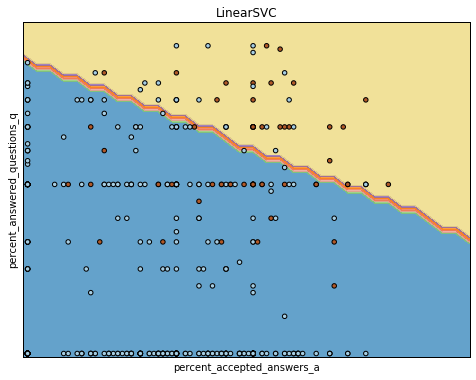

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

good_list = [
    ('code_line_count_a', 'reputation_a'),
    ('code_line_count_a', 'reputation_q'),
    ('code_line_count_a', 'view_count'),
    
    ('code_line_count_q', 'reputation_a'),
    ('code_line_count_q', 'reputation_q'),
    ('code_line_count_q', 'view_count'),
    
    ('reputation_a', 'reputation_q'),
    ('reputation_a', 'view_count'),
    
    ('reputation_q', 'view_count'),
]

bad_list = [
    ('code_line_count_a', 'code_line_count_q'),
    ('code_line_count_a', 'comment_count_a'),
    ('code_line_count_a', 'comment_count_q'),
    ('code_line_count_a', 'percent_accepted_answers_a'),
    ('code_line_count_a', 'percent_answered_questions_q'),
    ('code_line_count_a', 'score_a'),
    ('code_line_count_a', 'score_q'),

    ('code_line_count_q', 'comment_count_a'),
    ('code_line_count_q', 'comment_count_q'),
    ('code_line_count_q', 'percent_accepted_answers_a'),
    ('code_line_count_q', 'percent_answered_questions_q'),
    ('code_line_count_q', 'score_a'),
    ('code_line_count_q', 'score_q'),
    
    ('percent_answered_questions_q', 'reputation_a'),
    ('percent_answered_questions_q', 'reputation_q'),
    ('percent_answered_questions_q', 'score_a'),
    ('percent_answered_questions_q', 'score_q'),
    ('percent_answered_questions_q', 'view_count'),
    
    ('reputation_a', 'score_a'),
    ('reputation_a', 'score_q'),
    
    ('reputation_q', 'score_a'),
    ('reputation_q', 'score_q'),
]

bad_cat = [
    'answer_count',
    'comment_count_a',
    'comment_count_q',
    'percent_accepted_answers_a',
    'score_a',
    'score_q',
]

# for c1 in feature_names:
#     if c1 not in bad_cat:
#         for c2 in feature_names:
#             if c1 < c2 and (c1, c2) not in good_list and (c1, c2) not in bad_list:
#             if (c1, c2) in good_list:
#                 print((c1, c2))
#                 input()

c2 = 'percent_answered_questions_q'
c1 = 'percent_accepted_answers_a'

n_samples = 1000
X_aux = X_train[[c1, c2]].sample(n_samples, random_state=0)
y_aux = y_train.sample(n_samples, random_state=0)

X_vis = np.array(X_aux)
y_vis = np.array(y_aux)

h = 3  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
# lin_svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#              intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#              multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#              verbose=0).fit(X_vis, y_vis)

# create a mesh to plot in
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['LinearSVC']


for i, clf in enumerate((lin_svc,)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 1, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=plt.cm.Paired)
    plt.xlabel(c1)
    plt.ylabel(c2)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()
